# Integration geospatial raster-vector data in VKG system Ontop

## 0. Imports

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import random
import re
np.set_printoptions(threshold=sys.maxsize) # to display the entire array

# Geospatial Pkgs 
import xarray as xr
import gdal
from affine import Affine
from gdalconst import *
from osgeo import osr
import shapefile as sh
import geopandas as gpd
import fiona
import shapely
from shapely.geometry import LineString, MultiPolygon, Polygon, box, MultiPoint, Point
from shapely import wkt
from shapely.wkt import loads
from shapely.ops import unary_union
from wktplot import WKTPlot
from wktplot.plots.osm import OpenStreetMapsPlot #### Import OpenStreetMaps plotting class

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
# from bokeh.plotting import figure, show
# from bokeh.io import output_notebook
# from IPython.display import Image
# output_notebook()

from platform import python_version
print(f"Py version {python_version()}")
print(f"Shapely version {shapely.geos_version_string}")

Py version 3.8.10
Shapely version 3.11.1


## 1. Functions

In [389]:
def grid2WKT_polygon(long_array, lat_array):
    """Create the polygon geometry with requires at least 2 pairs of long, lat coordinates."""
    polygon = Polygon(zip(long_array, lat_array))
    return polygon.wkt

# def grid2WKT_polygon_02(long_array, lat_array):
#     """Create the polygon geometry with requires at least 2 pairs of long, lat coordinates."""
#     coordinates = list(zip(x_grid, y_grid))
#     polygon = "POLYGON((" + ", ".join(f"{y} {x}" for x, y in coordinates) + "))"
#     return polygon

# def wktDisplay(polygon):
#     # Create plot object just like standard WKTPlot class
#     plot = OpenStreetMapsPlot("Open Street Map Plot", 
#                               height=600,
#                               width=600,
#                               disable_mercator=False)
#     plot.add_shape(polygon, fill_alpha=0.5, fill_color="firebrick")
#     plot.show()
    
# def GetExtent(ds):
#     """ Return list of corner coordinates from a gdal Dataset """
#     xmin, xpixel, _, ymax, _, ypixel = ds.GetGeoTransform()
#     width, height = ds.RasterXSize, ds.RasterYSize
#     xmax = xmin + width * xpixel
#     ymin = ymax + height * ypixel
#     extent_dict = {
#       'lons_width': width, 
#       'lats_height': height, 
#       'xpixel': xpixel, 
#       'ypixel': ypixel,
#       'Upper_Left':[xmin, ymax],
#       'Bottom_Left':[xmin, ymin],
#       'Upper_Right':[xmax, ymax],
#       'Bottom_Right':[xmax, ymin]        
#     }
#     return extent_dict
#     #return (xmin, ymax), (xmax, ymax), (xmax, ymin), (xmin, ymin), (xpixel, ypixel), (width, height)

upper_right_lat_y
lower_left_lat_y
upper_right_lon_x 
lower_left_lon_x
pixel_size = 0.00833333333258679
   
def geo2grid(lons, lats, xmin, ymax, pixel_size, xskew = 0.0, yskew = 0.0):
    """ Translate geo indices to grid indices """
    # Geotransform object
    aff_gdal = Affine.from_gdal(xmin, pixel_size, xskew, ymax, yskew, -pixel_size)
    # coordinate data
    lons = np.array(lons)
    lats = np.array(lats)
    xs, ys = ~aff_gdal*(lons, lats)
    xs = np.int64(xs)
    ys = np.int64(ys)
#     print(xs)
#     print(ys)
    return xs, ys 

def add_closing_coordinates(d):
    d = str(d)
    """ Adds the first 'lat long' to the end"""
    i = re.search(r"\d", d).start()
    j = re.search(r'(\d)[^\d]*$', d).start() + 1
    c = d.index(',')    
    return d[:j] + ", " + d[i:c] + d[j:]

# def add_closing_coordinates_holes(d):
#     """ Adds the first 'lat long' to the end for polygons with one hole"""
#     # Find the start of the first set of coordinates in the exterior ring
#     i_exterior = re.search(r"\d", d).start()
    
#     # Find the end of the interior ring (hole)
#     j_interior = re.search(r'(\d)[^\d]*$', d).start() + 1
    
#     # Find the comma separating the lat and long in the exterior ring
#     c_exterior = d.index(',')

#     # Find the comma separating the lat and long in the interior ring
#     c_interior = d[j_interior:].index(',') + j_interior
    
#     # Concatenate the exterior ring and the first set of coordinates to close it
#     result = d[:c_exterior] + d[i_exterior:c_exterior] + d[c_exterior:]

#     # Concatenate the interior ring and the first set of coordinates to close it
#     result = result[:c_interior] + d[i_exterior:c_exterior] + result[c_interior:]

#     return result


# def geoPOLYGON_to_gridPOLYGON(polygon_str):
#     data = str(polygon_str)
#     data_wkt = add_closing_coordinates(data)
#     polygon = wkt.loads(data_wkt)
#     coords = np.dstack(polygon.boundary.xy).tolist()[0][:-1]
#     expected_list_of_coordinates_for_received_code = [{"long": x, "lat": y} for x, y in coords]
#     lat_arr = []
#     long_arr = []
#     for i in range(len(expected_list_of_coordinates_for_received_code)):
#         long_arr = np.append(long_arr, expected_list_of_coordinates_for_received_code[i]['long'])
#         lat_arr = np.append(lat_arr, expected_list_of_coordinates_for_received_code[i]['lat'])
    
#     long_list = long_arr.tolist()
#     lat_list = lat_arr.tolist()
    
#     return long_list, lat_list

def processPOLYGON(polygon_str):
    polygon = wkt.loads(add_closing_coordinates(polygon_str))
    coords = np.dstack(polygon.boundary.xy).tolist()[0][:-1]
    expected_list_of_coordinates_for_received_code = [{"long": x, "lat": y} for x, y in coords]
    lat_arr = []
    long_arr = []
    for i in range(len(expected_list_of_coordinates_for_received_code)):
        long_arr = np.append(long_arr, expected_list_of_coordinates_for_received_code[i]['long'])
        lat_arr = np.append(lat_arr, expected_list_of_coordinates_for_received_code[i]['lat'])
    
    long_list = long_arr.tolist()
    lat_list = lat_arr.tolist()
    
    x_grid, y_grid = geo2grid(long_list, lat_list, xmin, ymax, pixel_size)
    gridPOLYGON_yx = grid2WKT_polygon(y_grid, x_grid)
    
    return gridPOLYGON_yx

           
def geoPOLYGON_to_gridPOLYGON_03(polygon_str, regionID = None):
    polygons_array = []
    i = 0
    if polygon_str.geom_type == 'Polygon':
        return processPOLYGON(polygon_str)
    elif len(breakMULTIPOLYGONS(INPUT)[0].interiors) > 0:
        print(f"{regionID}: Inner Rings detected")
    else:
        for polygon in polygon_str.geoms:
            gridPOLYGON = processPOLYGON(polygon)
            polygons_array.append(gridPOLYGON)
            i = i +1
            #print(f"flag {i}") # i th inner polygon
            
        gridMULTI =  [shapely.wkt.loads(poly) for poly in polygons_array]
        return shapely.geometry.MultiPolygon(gridMULTI)
          
        
def breakMULTIPOLYGONS(multipolygon):
    """Convert MULTIPOLYGON to a list of polygons"""
    polygons_array = []
    if multipolygon.geom_type == 'Polygon':
        return str("")
    else:
        for polygon in multipolygon.geoms:
            polygons_array.append(polygon)

#     print("# of internal polygons is ",len(polygons_array))
    return polygons_array

def repairMULTIPOLYGONS(multipolygon):
    """Convert MULTIPOLYGON to a list of polygons"""
    polygons_array = []
    if multipolygon.geom_type == 'Polygon':
        print("Flag 1")
        return str("")
    else:
        print("Flag 2")
        for polygon in multipolygon.geoms:
            polygon = wkt.loads(add_closing_coordinates(str(polygon)))
            polygons_array.append(polygon)
    print("Flag 3")
    return unary_union(polygons_array)

def checkMULTIPOLYGONS(df):
   """checks if a vector data has multipolygons"""
   df = df.assign(isMULTI=df['geometry'].apply(lambda row :len(breakMULTIPOLYGONS(wkt.loads(str(row))))))
   df_multipolygons = df[df['isMULTI'] > 0]
   view = pd.DataFrame({'Districts':df_multipolygons['NAME_2'],'MultiPolygons':df_multipolygons['isMULTI']})
   return view


######## GIS F(X) ##############################################################################################
################################################################################################################

def query2array2visuallize(query, title=None, fill_val=None):
    result = query_executor.execute_read(query) 
    # array conversion and cleaning
    numpy_array = result.to_array()
    if fill_val is not None:
        numpy_array = numpy_array.astype('float')
        numpy_array[numpy_array == fill_val] = 'nan'
        data = numpy_array
    else:
        # Data for the heat map
        data = numpy_array
    # Function to show the heat map
    ax = sns.heatmap( data , cmap = 'Spectral_r')
    # Adding details to the plot
    plt.rcParams["figure.figsize"]=(7,5)
    plt.title(title)
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    # Displaying the plot
    plt.show()
    return True #return numpy_array   

def query2array(query, fill_val=None):
    result = query_executor.execute_read(query) 
    # array conversion and cleaning
    numpy_array = result.to_array()
    if fill_val is not None:
        numpy_array = numpy_array.astype('float')
        numpy_array[numpy_array == fill_val] = 'nan'
        return numpy_array
    else:
        return numpy_array
    
def query2result(query):
    result = query_executor.execute_read(query) 
    print(result)
    print(type(result))
    return float("{}".format(result))

def visuallizeARRAY(data, title="Beautiful Image but please put a signifaciant title"):
    """accept an array and return shape and visualize the array in heat map"""
    data = np.array(data)
    if len(data.shape) > 1:
        ax = sns.heatmap(np.array(data) , cmap = 'Spectral_r') #inferno
    else:
        ax = sns.heatmap(data[:, np.newaxis], cmap='Spectral_r')
    # Adding details to the plot
    plt.rcParams["figure.figsize"]=(7,5)
    plt.title(title)
    plt.xlabel('x-axis')
    plt.ylabel('y-axis')
    # Displaying the plot
    plt.show()
    return np.array(data).shape

## 2. Explainatory Data Analysis

### 2.1 Geometric Vector Data (relational data)

In [390]:
gdfBAV = gpd.read_file('/home/arkaghosh/Downloads/Baveria/Vector/Baveria_1.shp')
gdfSWE = gpd.read_file('/home/arkaghosh/Downloads/rasdapy3_dir/SWE_adm/SWE_adm2.shp')

In [4]:
view = pd.DataFrame({'Districts':gdfBAV['NAME_2'],'geom':gdfBAV['geometry']})
view

,Districts,geom
0,Aichach-Friedberg,"POLYGON ((11.03899 48.22127, 11.04266 48.22036..."
1,Altötting,"POLYGON ((12.61187 48.06424, 12.60968 48.06479..."
2,Amberg,"POLYGON ((11.78115 49.42765, 11.78099 49.42811..."
3,Amberg-Sulzbach,"POLYGON ((11.96819 49.61406, 11.96912 49.61361..."
4,Ansbach,"POLYGON ((10.66370 49.08374, 10.66685 49.08319..."
...,...,...
91,Weilheim-Schongau,"POLYGON ((10.97286 47.69561, 10.97356 47.69552..."
92,Weißenburg-Gunzenhausen,"POLYGON ((11.04477 48.90070, 11.04352 48.89983..."
93,Wunsiedel im Fichtelgebirge,"POLYGON ((11.90024 49.98885, 11.89903 49.98987..."
94,Würzburg,"POLYGON ((9.93395 49.48361, 9.92981 49.48433, ..."


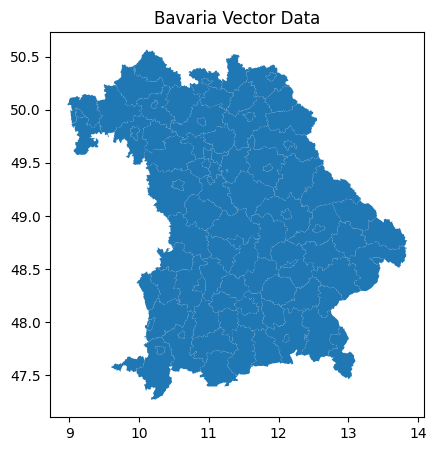

In [5]:
f, ax1 = plt.subplots(figsize=(6, 5))
gdfBAV.plot(ax=ax1)
# Add a title to your plot
ax1.set(title="Bavaria Vector Data")
plt.show()

In [6]:
# gdfBAV_multipolygons = gdfBAV[gdfBAV['isMULTI'] > 0]
# view = pd.DataFrame({'Districts':gdfBAV_multipolygons['NAME_2'],'MultiPolygons':gdfBAV_multipolygons['isMULTI']})
# view

In [7]:
checkMULTIPOLYGONS(gdfSWE)

,Districts,MultiPolygons
0,Ödeshög,3
1,Åtvidaberg,2
2,Boxholm,2
8,Norrköping,88
9,Söderköping,133
...,...,...
275,Tanum,122
276,Tibro,2
278,Tjörn,54
281,Uddevalla,24


### 2.2 Raster Data (multi-dimensional arrays)

#### 2.1.1 Geotiff

#### 2.2.2 NetCDF

In [8]:
raster01_path = '/home/arkaghosh/Downloads/Baveria/Raster/Baveria_Temp_MOD11A1.061_1km_aid0001.nc'
raster02_path = '/home/arkaghosh/Downloads/RASDAMAN_FINALE/Worked/Sweden/Temperature_1km.nc'

In [9]:
f = xr.open_dataset(raster01_path)
lons = f['lon'].values
lats = f['lat'].values
lst_var = f['LST_Night_1km'].values

In [347]:
xmax = float(f['lon'].max())
xmin = float(f['lon'].min())

ymin = float(f['lat'].min())
ymax = float(f['lat'].max())

In [348]:
xmin, xmax

(8.979166665862266, 13.837499998760364)

In [349]:
ymin, ymax

(47.270833329098565, 50.56249999547035)

#### 2.2.3 RasDaMan

In [11]:
# Rasdaman
from rasdapy.db_connector import DBConnector
from rasdapy.query_executor import QueryExecutor

db_connector = DBConnector("localhost", 7001, "rasadmin", "rasadmin")
query_executor = QueryExecutor(db_connector)
db_connector.open() # connection open

if db_connector is not None:
    print("RasDaMan is running") 
    
def restart_rasdaman():
    from rasdapy.db_connector import DBConnector
    from rasdapy.query_executor import QueryExecutor

    db_connector = DBConnector("localhost", 7001, "rasadmin", "rasadmin")
    query_executor = QueryExecutor(db_connector)
    db_connector.open() # connection open

RasDaMan is running


In [12]:
collection_list = query_executor.execute_read("select c from RAS_COLLECTIONNAMES as c")
collection_list

In [13]:
collection_list = list(collection_list)
collection_list

['AIR_TEMP_X',
 'Surface_Temperature_Sweden_lon_lat',
 'Surface_Temperature_Sweden_061',
 'LST_03_GeoTIFF',
 'Baveria_Temperature_MODIS_1km',
 'Surface_Temperature_Sweden',
 'LST_03_GeoTIFF_FLIPPED',
 'LST_03_GeoTIFF_FLIPPED_CRS',
 'World_Air_Temperature']

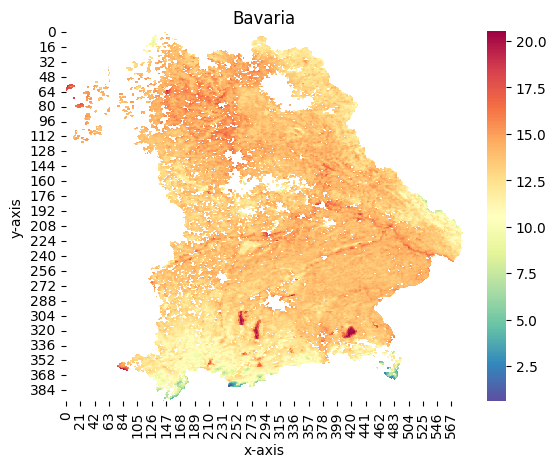

True

In [14]:
q = "select (mr[178, 0:* , 0:*]*0.02)-273.15 from Baveria_Temperature_MODIS_1km as mr" #100, 178
query2array2visuallize(q, "Bavaria",0)

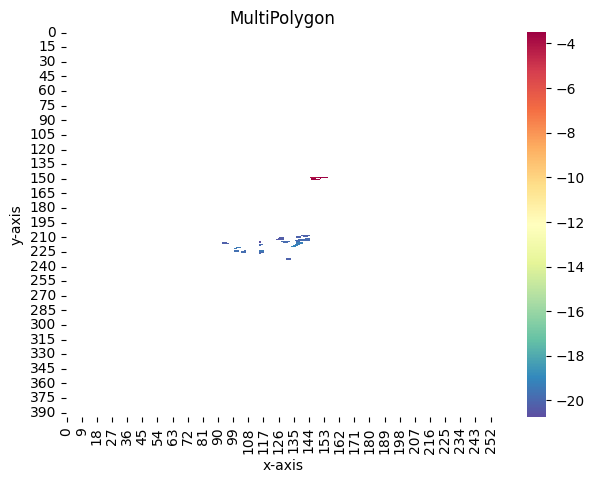

True

In [15]:
qUmea = "select clip((m[20, 0:* , 0:*]*0.02) - 273.15, MULTIPOLYGON(((100 200, 352 400, 384 441, 100 200)), ((1 457, 352 400, 384 441, 1 457)),((400 315, 150 315, 150 360,400 315 )))) from Baveria_Temperature_MODIS_1km as m" 
query2array2visuallize(qUmea, "MultiPolygon", 0)

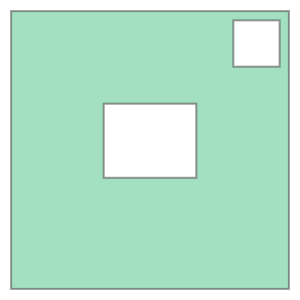

In [281]:
polygon = Polygon(

    shell=[(0, 0), (0, 300), (300, 300), (300, 0), (0, 0)],

    holes=[[(100, 120), (200, 120), (200, 200), (100, 200), (100, 120)],[(240, 240), (240, 290), (290, 290), (290, 240), (240, 240)]],

)

polygon

In [282]:
print(polygon)

POLYGON ((0 0, 0 300, 300 300, 300 0, 0 0), (100 120, 200 120, 200 200, 100 200, 100 120), (240 240, 240 290, 290 290, 290 240, 240 240))


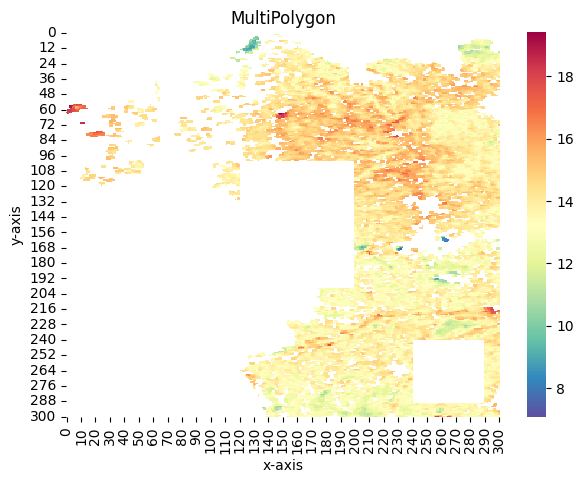

True

In [283]:
qUmea = "select clip((m[178, 0:* , 0:*]*0.02) - 273.15, POLYGON ((0 0, 0 300, 300 300, 300 0, 0 0), (100 120, 200 120, 200 200, 100 200, 100 120), (240 240, 240 290, 290 290, 290 240, 240 240))) from Baveria_Temperature_MODIS_1km as m" 
query2array2visuallize(qUmea, "MultiPolygon", 0)

## 3. Resolving Issues

### ISSUE #01: Automate Metadata Retrival for each raster

#### Necessary Metadata for raster data

In [351]:
xmin, xmax

(8.979166665862266, 13.837499998760364)

In [352]:
ymin, ymax

(47.270833329098565, 50.56249999547035)

In [350]:
pixel_size = 0.00833333333258679

### ISSUE #02: Resolving Multipolygons in Vector Data

Some tips:

 1. https://blogs.sap.com/2016/08/30/importing-shapefiles-in-sap-hana-and-the-validity-of-geometries/

In [16]:
checkMULTIPOLYGONS(gdfBAV)

,Districts,MultiPolygons
12,Bamberg,2
15,Bayreuth (Kreisfreie Stadt),2
16,Berchtesgadener Land,2
17,Cham,8
59,München (Kreisfreie Stadt),2
65,Nürnberg,2
67,Oberallgäu,2
68,Ostallgäu,2
75,Rhön-Grabfeld,2
76,Rosenheim,4


### Rosenheim

Rosenheim


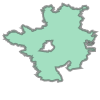

In [392]:
gid = 76 #76 
print(gdfBAV.NAME_2[gid])
INPUT = gdfBAV.geometry[gid]
INPUT

In [393]:
geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)

76: Inner Rings detected


In [394]:
mulPOLY = breakMULTIPOLYGONS(INPUT)
mulPOLY

[<POLYGON ((12.2 47.64, 12.201 47.638, 12.201 47.637, 12.202 47.636, 12.202 4...>,
 <POLYGON ((12.414 47.86, 12.414 47.86, 12.414 47.86, 12.414 47.86, 12.414 47...>,
 <POLYGON ((12.415 47.868, 12.415 47.868, 12.415 47.869, 12.416 47.869, 12.41...>,
 <POLYGON ((12.425 47.876, 12.426 47.876, 12.426 47.876, 12.426 47.876, 12.42...>]

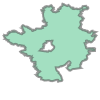

In [395]:
mulPOLY[0]

In [396]:
len(list(mulPOLY[0].exterior.coords))

3648

In [397]:
len(list(mulPOLY[0].interiors))

1

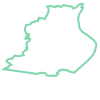

In [398]:
list(mulPOLY[0].interiors)[0]

In [399]:
list(mulPOLY[0].interiors)[0].geom_type

'LinearRing'

In [400]:
for i in range(0, len(INPUT.geoms)):
    print(len(breakMULTIPOLYGONS(INPUT)[i].interiors))

1
0
0
0


In [401]:
len(breakMULTIPOLYGONS(INPUT)[0].interiors)

1

In [402]:
len(breakMULTIPOLYGONS(INPUT)[3].interiors)

0

In [403]:
list(breakMULTIPOLYGONS(INPUT)[0].interiors)[0].geom_type

'LinearRing'

In [405]:
len((INPUT.geoms))

4

In [43]:
# INPUT string
input_string = "POLYGON ((0 0, 0 300, 300 300, 300 0, 0 0), (100 120, 200 120, 200 200, 100 200, 100 120), (240 240, 240 290, 290 290, 290 240, 240 240))"

# Define a pattern to match polygons within parentheses
pattern = re.compile(r'\(([^)]+)\)')
# pattern = re.compile(r'\([^)]+\)')
# Use findall to extract all matches
polygons = pattern.findall(input_string)

# # Print individual polygons
# for i, polygon in enumerate(polygons, start=1):
#     print(f"({polygon})")
#     print("-------------------------------------------------------------")

# Assemble the polygons again
assembled_string = "POLYGON " + ", ".join(f"({polygon})" for polygon in polygons) + ")"
print("\nAssembled String:")
print(assembled_string)


Assembled String:
POLYGON ((0 0, 0 300, 300 300, 300 0, 0 0), (100 120, 200 120, 200 200, 100 200, 100 120), (240 240, 240 290, 290 290, 290 240, 240 240))


In [23]:
polygons

['(0 0, 0 300, 300 300, 300 0, 0 0',
 '100 120, 200 120, 200 200, 100 200, 100 120',
 '240 240, 240 290, 290 290, 290 240, 240 240']

In [24]:
# INPUT string
input_string = str(mulPOLY[0])

# Define a pattern to match polygons within parentheses
pattern = re.compile(r'\(([^)]+)\)')

# Use findall to extract all matches
polygons = pattern.findall(input_string)

# Print individual polygons
for i, polygon in enumerate(polygons, start=1):
    print(f"({polygon})")
    print("--------------------------------------------------------------------------------------------------")

# # Assemble the polygons again
# assembled_string = "POLYGON " + ", ".join(f"({polygon})" for polygon in polygons) + ")"
# print("\nAssembled String:")
# print(assembled_string)

((12.200161721000029 47.64013822700002, 12.200831974000153 47.63832113400008, 12.20115869000017 47.63741699900015, 12.201745728000049 47.635656199000096, 12.202132202000087 47.634496923000086, 12.202205343000173 47.63427752000018, 12.20308260100012 47.63117171100015, 12.203171711000039 47.63085622400007, 12.20332435400013 47.62861527899997, 12.203636109000058 47.62667949400014, 12.20367800200006 47.62641931100001, 12.204063286000178 47.6244087770001, 12.204291696000041 47.623539916000084, 12.20460580800011 47.62288023000019, 12.204982143000052 47.6221950690001, 12.206616982000071 47.61921847400009, 12.207421562000036 47.61772136100012, 12.207765814000084 47.61708076200017, 12.208263446000046 47.61599882500008, 12.208520962000023 47.61528756900003, 12.208723547000034 47.614612655000144, 12.208837907000088 47.61403789299999, 12.20888875899999 47.613434442000084, 12.208875864000106 47.61323794700007, 12.208851865000156 47.61287196100017, 12.208733554000048 47.6123095800001, 12.20849688300

In [26]:
# INPUT string
input_string = "POLYGON ((0 0, 0 300, 300 300, 300 0, 0 0), (100 120, 200 120, 200 200, 100 200, 100 120), (240 240, 240 290, 290 290, 290 240, 240 240))"

# Define a pattern to match polygons within parentheses
pattern = re.compile(r'\([^)]+\)')

# Use findall to extract all matches
polygons = pattern.findall(input_string)

In [27]:
polygons

['((0 0, 0 300, 300 300, 300 0, 0 0)',
 '(100 120, 200 120, 200 200, 100 200, 100 120)',
 '(240 240, 240 290, 290 290, 290 240, 240 240)']

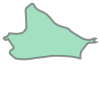

In [406]:
mulPOLY[1]

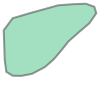

In [407]:
mulPOLY[2]

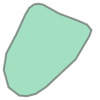

In [408]:
mulPOLY[3]

In [411]:
geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)

76: Inner Rings detected


In [412]:
INPUT.geom_type

'MultiPolygon'

### München (Kreisfreie Stadt)

München (Kreisfreie Stadt)


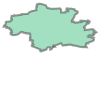

In [413]:
gid = 59 #58, 59 doesn't work
print(gdfBAV.NAME_2[gid])
INPUT = gdfBAV.geometry[gid]
INPUT

In [414]:
len((INPUT.geoms))

2

In [415]:
len(breakMULTIPOLYGONS(INPUT)[0].interiors)

0

In [416]:
for i in range(0, len(INPUT.geoms)):
    print(len(breakMULTIPOLYGONS(INPUT)[i].interiors))

0
0


In [417]:
mulPOLY = breakMULTIPOLYGONS(INPUT)
mulPOLY

[<POLYGON ((11.557 48.079, 11.555 48.079, 11.555 48.08, 11.557 48.081, 11.559...>,
 <POLYGON ((11.405 48.202, 11.405 48.202, 11.407 48.202, 11.416 48.203, 11.41...>]

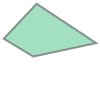

In [418]:
mulPOLY[0]

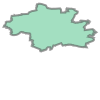

In [419]:
mulPOLY[1]

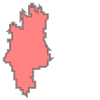

In [420]:
geoPOLYGON_to_gridPOLYGON_03(INPUT)

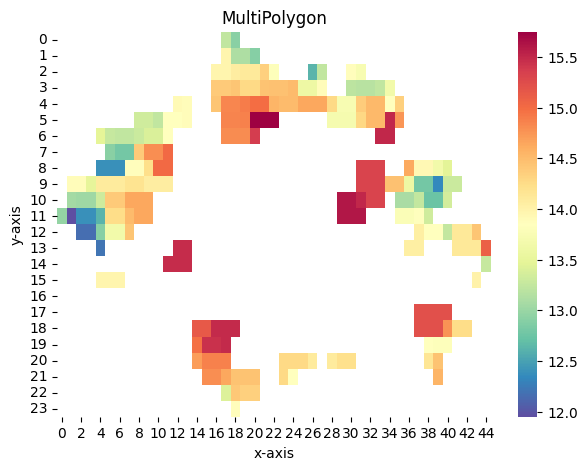

True

In [421]:
qCham = 'select clip((m[178, 0:* , 0:*]*0.02) - 273.15,'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT)) + ') from Baveria_Temperature_MODIS_1km as m'
query2array2visuallize(qCham, "MultiPolygon", 0)

### Cham

Cham


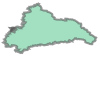

In [422]:
gid = 17 #58, 59 doesn't work
print(gdfBAV.NAME_2[gid])
INPUT = gdfBAV.geometry[gid]
INPUT

In [423]:
mulPOLY = breakMULTIPOLYGONS(INPUT)
mulPOLY

[<POLYGON ((12.495 49.061, 12.494 49.061, 12.493 49.06, 12.493 49.06, 12.493 ...>,
 <POLYGON ((12.372 49.237, 12.372 49.237, 12.374 49.238, 12.374 49.238, 12.37...>,
 <POLYGON ((12.379 49.241, 12.381 49.241, 12.385 49.241, 12.385 49.24, 12.381...>,
 <POLYGON ((12.371 49.243, 12.373 49.245, 12.373 49.245, 12.376 49.245, 12.37...>,
 <POLYGON ((12.395 49.25, 12.395 49.25, 12.392 49.251, 12.392 49.251, 12.39 4...>,
 <POLYGON ((12.368 49.26, 12.37 49.259, 12.37 49.259, 12.372 49.26, 12.373 49...>,
 <POLYGON ((12.385 49.267, 12.385 49.267, 12.387 49.267, 12.387 49.267, 12.38...>,
 <POLYGON ((12.408 49.264, 12.408 49.264, 12.407 49.264, 12.405 49.264, 12.40...>]

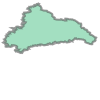

In [424]:
mulPOLY[0]

In [425]:
len(list(mulPOLY[0].exterior.coords))

2585

In [426]:
len(list(mulPOLY[0].interior))

AttributeError: 'Polygon' object has no attribute 'interior'

In [427]:
 len(list(breakMULTIPOLYGONS(INPUT)[0])

SyntaxError: unexpected EOF while parsing (3139195035.py, line 1)

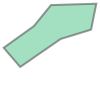

In [428]:
mulPOLY[1]

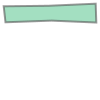

In [429]:
mulPOLY[2]

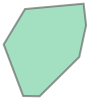

In [430]:
mulPOLY[3]

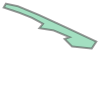

In [431]:
mulPOLY[4]

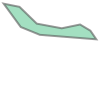

In [432]:
mulPOLY[5]

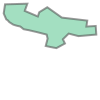

In [433]:
mulPOLY[6]

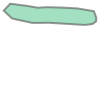

In [434]:
mulPOLY[7]

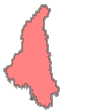

In [435]:
x = geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)
x

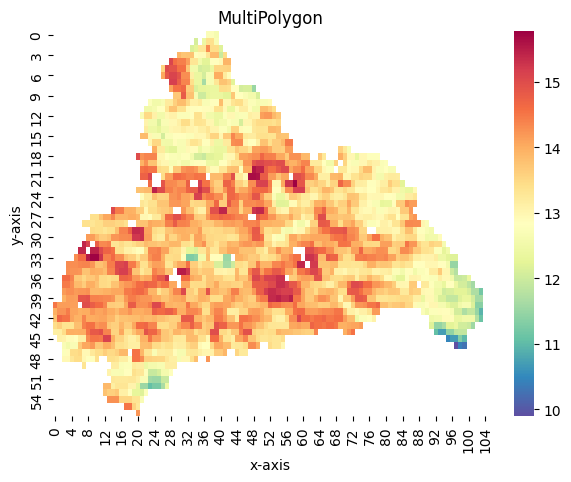

True

In [436]:
qCham = 'select clip((m[178, 0:* , 0:*]*0.02) - 273.15,'+ str(geoPOLYGON_to_gridPOLYGON_03(INPUT)) + ') from Baveria_Temperature_MODIS_1km as m'
query2array2visuallize(qCham, "MultiPolygon", 0)

In [491]:
poly_1 = Polygon([(20,20), (60,20), (60,40), (20,40)])
poly_2 = Polygon([(60,50), (60,70), (80,70), (80,50)])
 
polygons = unary_union([poly_1, poly_2])
print(polygons)

MULTIPOLYGON (((20 40, 60 40, 60 20, 20 20, 20 40)), ((60 70, 80 70, 80 50, 60 50, 60 70)))


In [500]:
type(poly_1)

shapely.geometry.polygon.Polygon

In [492]:
print(repairMULTIPOLYGONS(polygons))

Flag 2
Flag 3
MULTIPOLYGON (((60 40, 60 20, 20 20, 20 40, 60 40)), ((80 70, 80 50, 60 50, 60 70, 80 70)))


In [496]:
poly = geoPOLYGON_to_gridPOLYGON_03(polygons)

Flag 1
Flag 1


In [499]:
type(poly[1])

str

Oberallgäu


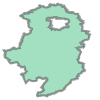

In [331]:
gid = 67 #58, 59 doesn't work
print(gdfBAV.NAME_2[gid])
INPUT = gdfBAV.geometry[gid]
INPUT

In [332]:
INPUT.geom_type

'MultiPolygon'

In [437]:
INPUT_str = str(INPUT)
INPUT_str.geom_type

AttributeError: 'str' object has no attribute 'geom_type'

In [334]:
INPUT_str = wkt.loads(INPUT_str)
INPUT_str.geom_type

'MultiPolygon'

In [335]:
geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)

67: Inner Rings detected


In [280]:
countEX = 0
vectorDB = gdfBAV
for gid in range(0,len(vectorDB)):
    INPUT = vectorDB.geometry[gid]
    try:
        geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)
#         print(f"{gid}:{vectorDB.NAME_2[gid]}")
    except:
        print(f"{gid}: {vectorDB.NAME_2[gid]}            <> GEOSException <>")
        countEX+=1
        
print("\nNumber of exceptions",countEX)

3: Amberg-Sulzbach            <> GEOSException <>
4: Ansbach            <> GEOSException <>
10: Bad Kissingen            <> GEOSException <>
12: Inner Rings detected
14: Bayreuth            <> GEOSException <>
18: Coburg            <> GEOSException <>
29: Erlangen-Höchstadt            <> GEOSException <>
38: Haßberge            <> GEOSException <>
39: Hof            <> GEOSException <>
49: Landshut            <> GEOSException <>
58: München            <> GEOSException <>
64: Neustadt an der Waldnaab            <> GEOSException <>
66: Nürnberger Land            <> GEOSException <>
67: Inner Rings detected
68: Inner Rings detected
73: Regensburg            <> GEOSException <>
76: Inner Rings detected
81: Schwandorf            <> GEOSException <>
82: Inner Rings detected
86: Straubing-Bogen            <> GEOSException <>
88: Traunstein            <> GEOSException <>
94: Würzburg            <> GEOSException <>

Number of exceptions 17


In [337]:
countEX = 0
vectorDB = gdfSWE
for gid in range(0,len(vectorDB)):
    INPUT = vectorDB.geometry[gid]
    try:
        geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)
#         print(f"{gid}:{vectorDB.NAME_2[gid]}")
    except:
        print(f"{gid}: {vectorDB.NAME_2[gid]}***")
        countEX+=1
        
print("\nNumber of exceptions",countEX)

2: Inner Rings detected
11: Inner Rings detected
20: Borlänge***
24: Leksand***
51: Åre***
52: Berg***
55: Inner Rings detected
60: Inner Rings detected
63: Nässjö***
66: Värnamo***
70: Emmaboda***
76: Inner Rings detected
82: Alvesta***
84: Ljungby***
89: Överkalix***
115: Flen***
120: Strängnäs***
127: Inner Rings detected
128: Bjuv***
132: Hässleholm***
147: Sjöbo***
151: Svedala***
152: Tomelilla***
181: Östhammar***
199: Säffle***
204: Bjurholm***
210: Inner Rings detected
211: Inner Rings detected
214: Inner Rings detected
215: Vännäs***
257: Inner Rings detected
263: Mellerud***
268: Skövde***
285: Vara***

Number of exceptions 24


Umeå


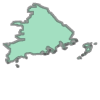

In [320]:
gid = 214
print(gdfSWE.NAME_2[gid])
INPUT = gdfSWE.geometry[gid]
INPUT

In [321]:
for i in range(0, len(INPUT.geoms)):
    print(len(breakMULTIPOLYGONS(INPUT)[i].interiors))

1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [274]:
geoPOLYGON_to_gridPOLYGON_03(INPUT, gid)

Inner Rings detected at regionID: 214


## 4. Source Preparaiton